In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Twitter16-TF"
unique_name = "BERT_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter16-TF_BERT_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(412, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter16-tf_dataset.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1,tvt2_2,tvt2_3
0,656955120626880512,correct predictions in back to the future ii U...,False,training,training,training,training
1,615689290706595840,.@whitehouse in rainbow colors for #scotusmarr...,True,testting,testting,training,testting
2,613404935003217920,cops bought the alleged church shooter burger ...,False,validation,training,training,training
3,614467824313106432,god put a rainbow over the white house 🌈 URL\r,True,validation,training,training,training
4,622891631293935616,#wakeupamerica🇺🇸 who needs a #gun registry whe...,False,training,testting,training,training


In [4]:
labels_str = [True, False]
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[1, 0, 1, 0, 1, 0, 0, 1, 1, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(275, 768)
(98, 768)
(39, 768)
(275,)
(98,)
(39,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(373, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(373,)


In [10]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_2LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [11]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 2-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 68.0
Saving after new best accuracy : 88.0
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.64429530201342, Validation Accuracy : 98.66666666666667, Train Loss : 0.09088171273469925, Validation Loss : 0.037823084741830826
-- Epoch 100, Train_Accuracy : 98.99328859060402, Validation Accuracy : 100.0, Train Loss : 0.03125619888305664, Validation Loss : 0.012431681156158447
-- Epoch 150, Train_Accuracy : 99.32885906040268, Validation Accuracy : 100.0, Train Loss : 0.012442406266927719, Validation Loss : 0.0036637361627072096
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0031454029958695173, Validation Loss : 0.0018181339837610722
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0011783757945522666, Validation Loss : 0.0011118483962491155
-- Epoch 300, Train_Accuracy : 

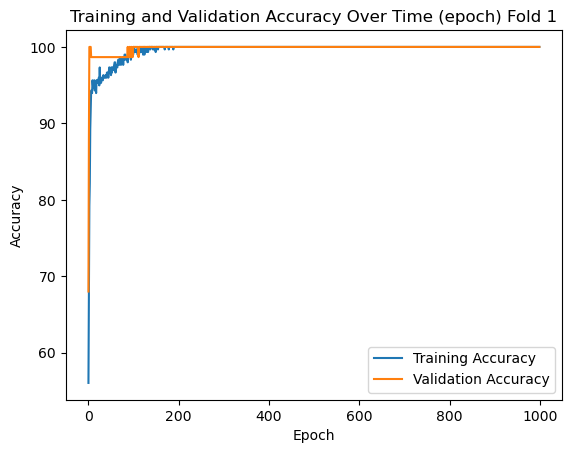

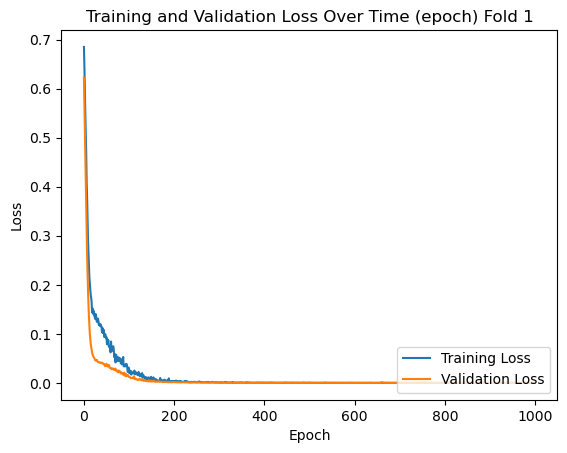

Exec Time : 8.73 seconds
loading model from ../../data/models/cross-validation/Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([298])
Binary Class Evaluation

True Positive : 117
False Positive : 3
False Negative : 31
True Negative : 147

Class False Evaluation
- Precision : 97.5 %
- Recall : 79.054 %
- F1 : 0.87313

Class True Evaluation
- Precision : 82.584 %
- Recall : 98.0 %
- F1 : 0.89634

Combined Evaluation
- Accuracy : 88.591 %
- Precision : 90.042 %
- Recall : 88.527 %
- F1 : 0.89278
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold1 Train, 88.591, 90.042, 88.527, 0.89278, 97.5, 79.054, 0.87313, 82.584, 98.0, 0.89634, 
Confusion Matrix Scikit-learn: 
[[147   3]
 [ 31 117]]


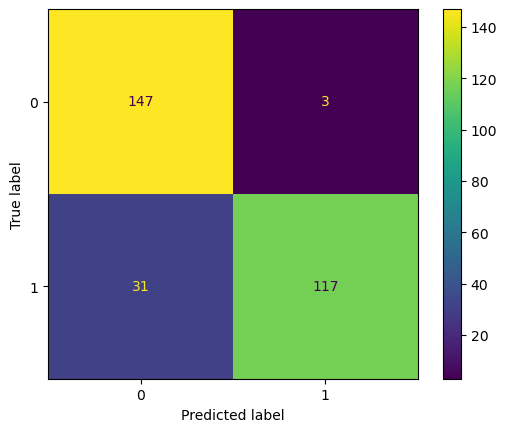


Validation Set
Predictions : torch.Size([75])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 38

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[38  0]
 [ 0 37]]


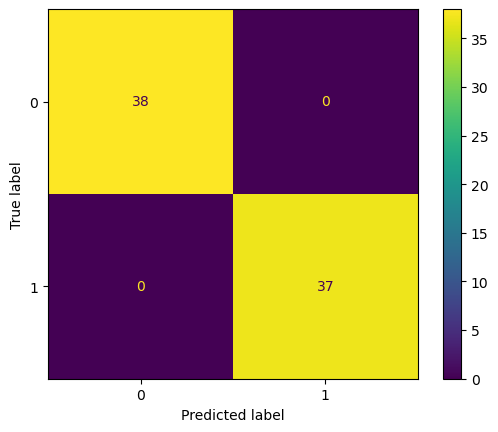


Test Set
Predictions : torch.Size([39])
Binary Class Evaluation

True Positive : 13
False Positive : 0
False Negative : 7
True Negative : 19

Class False Evaluation
- Precision : 100.0 %
- Recall : 65.0 %
- F1 : 0.78788

Class True Evaluation
- Precision : 73.077 %
- Recall : 100.0 %
- F1 : 0.84444

Combined Evaluation
- Accuracy : 82.051 %
- Precision : 86.538 %
- Recall : 82.5 %
- F1 : 0.84471
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold1 Test, 82.051, 86.538, 82.5, 0.84471, 100.0, 65.0, 0.78788, 73.077, 100.0, 0.84444, 
39
39
Confusion Matrix Scikit-learn: 
[[19  0]
 [ 7 13]]


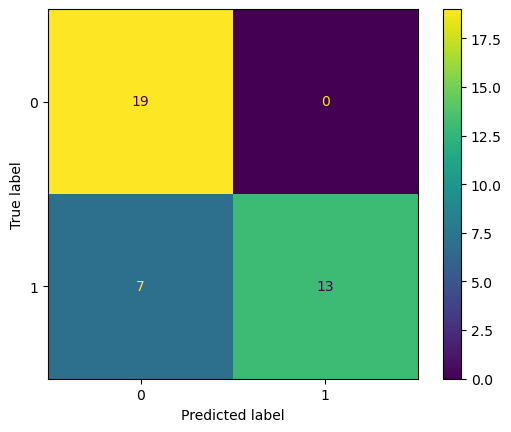

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 50.666666666666664
Saving after new best accuracy : 52.0
Saving after new best accuracy : 69.33333333333333
Saving after new best accuracy : 86.66666666666667
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.97986577181209, Validation Accuracy : 100.0, Train Loss : 0.09340167790651321, Validation Loss : 0.02179042249917984
-- Epoch 100, Train_Accuracy : 99.32885906040268, Validation Accuracy : 100.0, Train Loss : 0.025560159236192703, Validation Loss : 0.013304541818797588
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.006639481522142887, Validation Loss : 0.00792793370783329
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.002352501265704632, Validation Loss : 0.0052195205353200436
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0027815941721200943, Validation Loss : 0.004859587177634239
-- Epoch 300, T

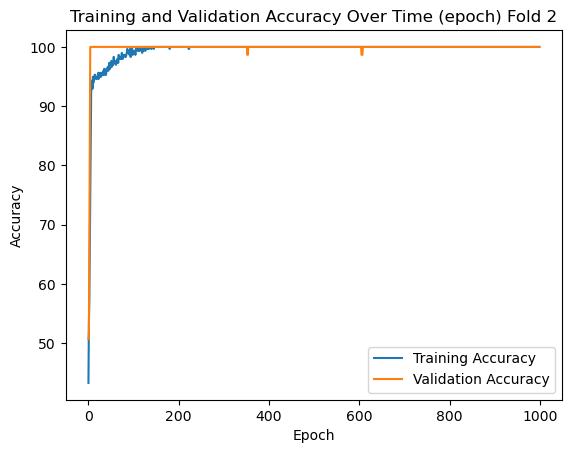

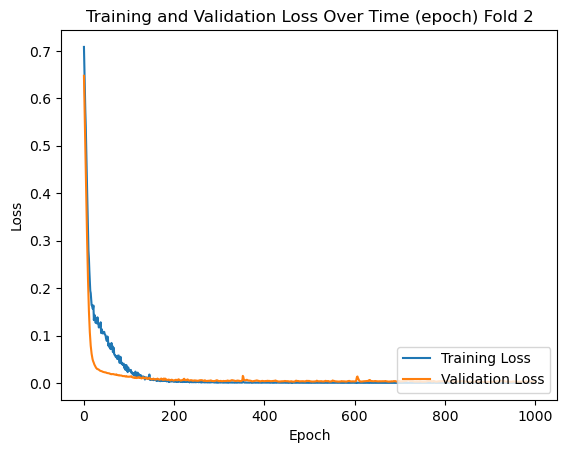

Exec Time : 6.84 seconds
loading model from ../../data/models/cross-validation/Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([298])
Binary Class Evaluation

True Positive : 132
False Positive : 2
False Negative : 16
True Negative : 148

Class False Evaluation
- Precision : 98.507 %
- Recall : 89.189 %
- F1 : 0.93617

Class True Evaluation
- Precision : 90.244 %
- Recall : 98.667 %
- F1 : 0.94268

Combined Evaluation
- Accuracy : 93.96 %
- Precision : 94.376 %
- Recall : 93.928 %
- F1 : 0.94151
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold2 Train, 93.96, 94.376, 93.928, 0.94151, 98.507, 89.189, 0.93617, 90.244, 98.667, 0.94268, 
Confusion Matrix Scikit-learn: 
[[148   2]
 [ 16 132]]


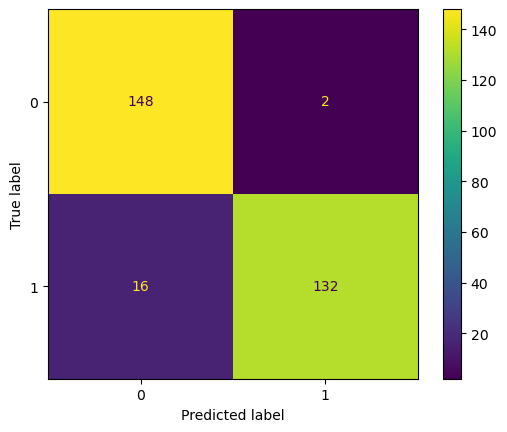


Validation Set
Predictions : torch.Size([75])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 38

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[38  0]
 [ 0 37]]


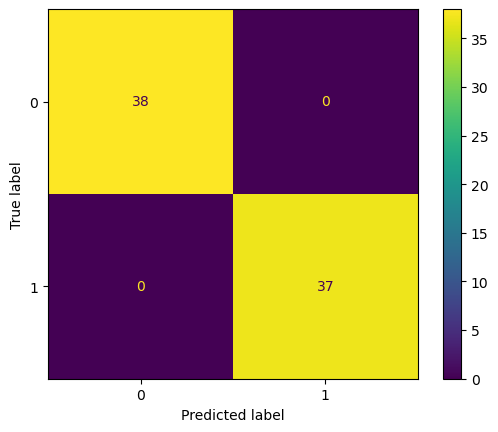


Test Set
Predictions : torch.Size([39])
Binary Class Evaluation

True Positive : 13
False Positive : 0
False Negative : 7
True Negative : 19

Class False Evaluation
- Precision : 100.0 %
- Recall : 65.0 %
- F1 : 0.78788

Class True Evaluation
- Precision : 73.077 %
- Recall : 100.0 %
- F1 : 0.84444

Combined Evaluation
- Accuracy : 82.051 %
- Precision : 86.538 %
- Recall : 82.5 %
- F1 : 0.84471
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold2 Test, 82.051, 86.538, 82.5, 0.84471, 100.0, 65.0, 0.78788, 73.077, 100.0, 0.84444, 
39
39
Confusion Matrix Scikit-learn: 
[[19  0]
 [ 7 13]]


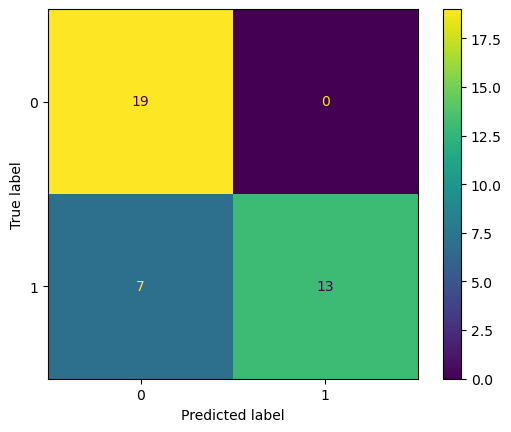

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 97.33333333333333
Saving after new best accuracy : 98.66666666666667
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 96.97986577181209, Validation Accuracy : 100.0, Train Loss : 0.0856233611702919, Validation Loss : 0.02076028287410736
-- Epoch 100, Train_Accuracy : 98.99328859060402, Validation Accuracy : 100.0, Train Loss : 0.0310799703001976, Validation Loss : 0.010399279184639454
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.006569824181497097, Validation Loss : 0.00376466428861022
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.005657981615513563, Validation Loss : 0.002369162393733859
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0019617355428636074, Validation Loss : 0.0016515010502189398
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0006527764489874244, Valid

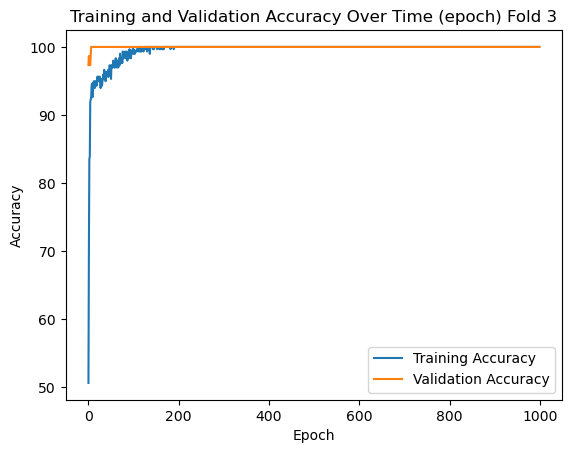

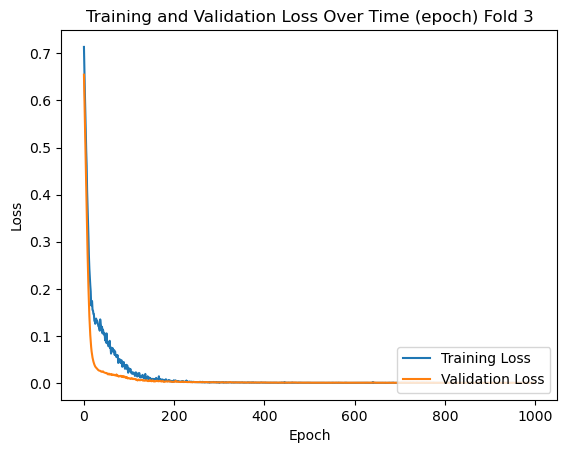

Exec Time : 7.06 seconds
loading model from ../../data/models/cross-validation/Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([298])
Binary Class Evaluation

True Positive : 139
False Positive : 8
False Negative : 9
True Negative : 142

Class False Evaluation
- Precision : 94.558 %
- Recall : 93.919 %
- F1 : 0.94237

Class True Evaluation
- Precision : 94.04 %
- Recall : 94.667 %
- F1 : 0.94352

Combined Evaluation
- Accuracy : 94.295 %
- Precision : 94.299 %
- Recall : 94.293 %
- F1 : 0.94296
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold3 Train, 94.295, 94.299, 94.293, 0.94296, 94.558, 93.919, 0.94237, 94.04, 94.667, 0.94352, 
Confusion Matrix Scikit-learn: 
[[142   8]
 [  9 139]]


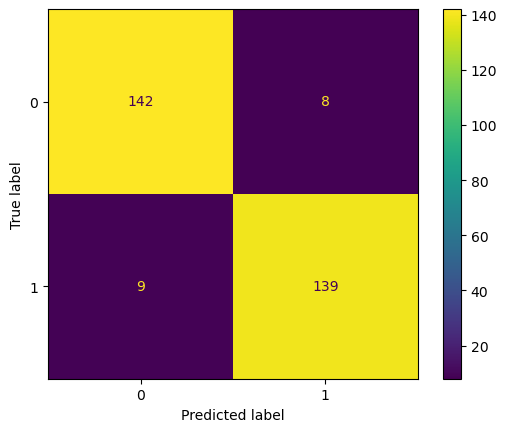


Validation Set
Predictions : torch.Size([75])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 0
True Negative : 38

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[38  0]
 [ 0 37]]


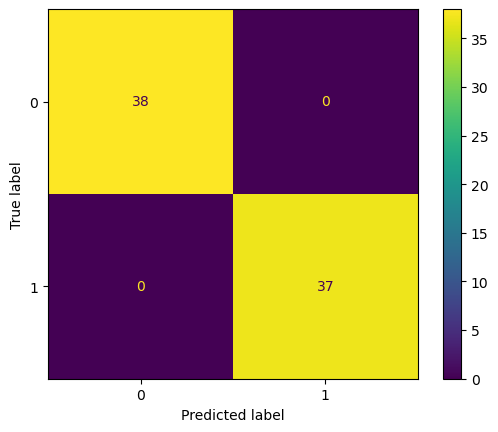


Test Set
Predictions : torch.Size([39])
Binary Class Evaluation

True Positive : 19
False Positive : 0
False Negative : 1
True Negative : 19

Class False Evaluation
- Precision : 100.0 %
- Recall : 95.0 %
- F1 : 0.97436

Class True Evaluation
- Precision : 95.0 %
- Recall : 100.0 %
- F1 : 0.97436

Combined Evaluation
- Accuracy : 97.436 %
- Precision : 97.5 %
- Recall : 97.5 %
- F1 : 0.975
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold3 Test, 97.436, 97.5, 97.5, 0.975, 100.0, 95.0, 0.97436, 95.0, 100.0, 0.97436, 
39
39
Confusion Matrix Scikit-learn: 
[[19  0]
 [ 1 19]]


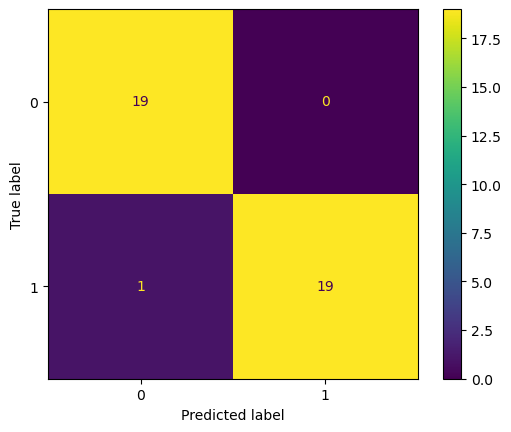

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 91.89189189189189
Saving after new best accuracy : 93.24324324324324
-- Epoch 50, Train_Accuracy : 97.9933110367893, Validation Accuracy : 93.24324324324324, Train Loss : 0.06841058284044266, Validation Loss : 0.2277422696352005
-- Epoch 100, Train_Accuracy : 99.33110367892976, Validation Accuracy : 93.24324324324324, Train Loss : 0.022342363372445107, Validation Loss : 0.18206842243671417
-- Epoch 150, Train_Accuracy : 99.66555183946488, Validation Accuracy : 93.24324324324324, Train Loss : 0.009570632129907608, Validation Loss : 0.19379056990146637
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 93.24324324324324, Train Loss : 0.003101968439295888, Validation Loss : 0.22370906174182892
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 93.24324324324324, Train Loss : 0.0013922506477683783, Validation Loss : 0.24471554160118103
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 93.24324324324324,

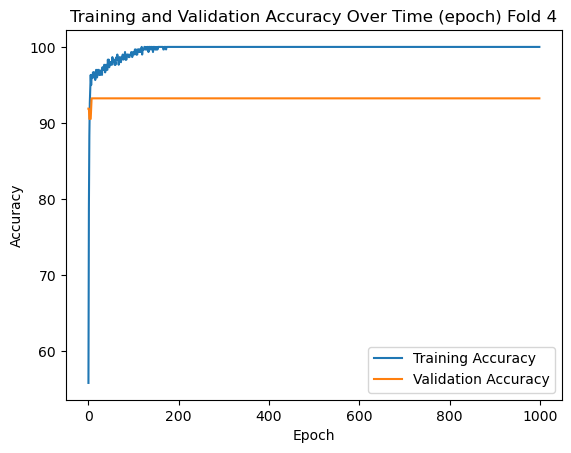

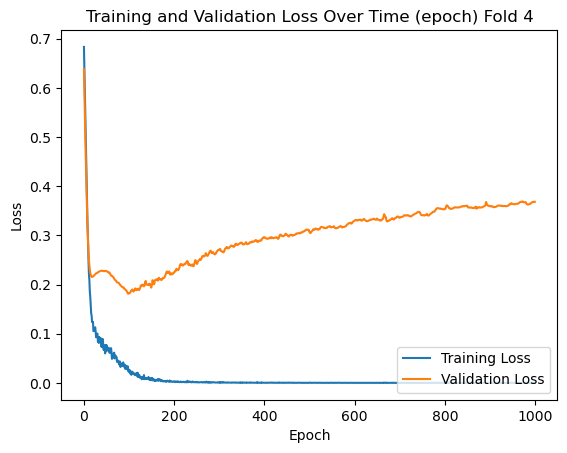

Exec Time : 7.0 seconds
loading model from ../../data/models/cross-validation/Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([299])
Binary Class Evaluation

True Positive : 143
False Positive : 6
False Negative : 5
True Negative : 145

Class False Evaluation
- Precision : 95.973 %
- Recall : 96.622 %
- F1 : 0.96296

Class True Evaluation
- Precision : 96.667 %
- Recall : 96.026 %
- F1 : 0.96346

Combined Evaluation
- Accuracy : 96.321 %
- Precision : 96.32 %
- Recall : 96.324 %
- F1 : 0.96322
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold4 Train, 96.321, 96.32, 96.324, 0.96322, 95.973, 96.622, 0.96296, 96.667, 96.026, 0.96346, 
Confusion Matrix Scikit-learn: 
[[145   6]
 [  5 143]]


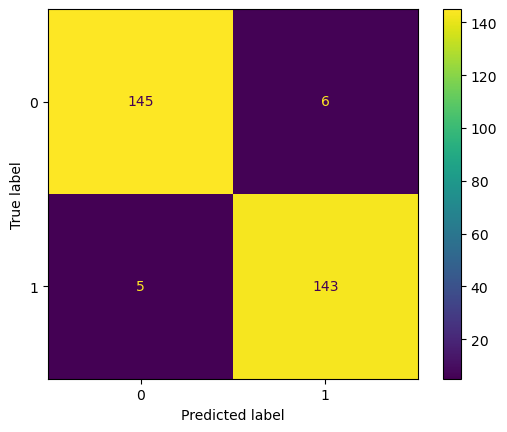


Validation Set
Predictions : torch.Size([74])
Binary Class Evaluation

True Positive : 35
False Positive : 3
False Negative : 2
True Negative : 34

Class False Evaluation
- Precision : 92.105 %
- Recall : 94.595 %
- F1 : 0.93333

Class True Evaluation
- Precision : 94.444 %
- Recall : 91.892 %
- F1 : 0.93151

Combined Evaluation
- Accuracy : 93.243 %
- Precision : 93.275 %
- Recall : 93.243 %
- F1 : 0.93259
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold4 Validation, 93.243, 93.275, 93.243, 0.93259, 92.105, 94.595, 0.93333, 94.444, 91.892, 0.93151, 
Confusion Matrix Scikit-learn: 
[[34  3]
 [ 2 35]]


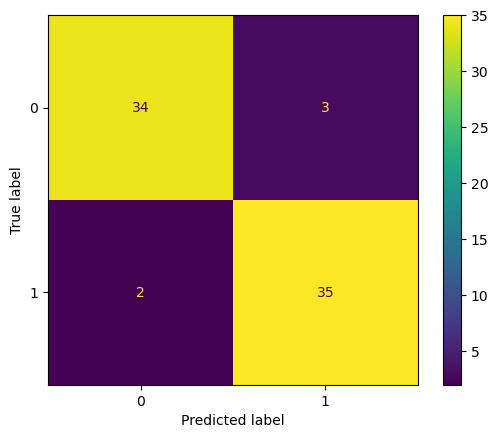


Test Set
Predictions : torch.Size([39])
Binary Class Evaluation

True Positive : 19
False Positive : 0
False Negative : 1
True Negative : 19

Class False Evaluation
- Precision : 100.0 %
- Recall : 95.0 %
- F1 : 0.97436

Class True Evaluation
- Precision : 95.0 %
- Recall : 100.0 %
- F1 : 0.97436

Combined Evaluation
- Accuracy : 97.436 %
- Precision : 97.5 %
- Recall : 97.5 %
- F1 : 0.975
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold4 Test, 97.436, 97.5, 97.5, 0.975, 100.0, 95.0, 0.97436, 95.0, 100.0, 0.97436, 
39
39
Confusion Matrix Scikit-learn: 
[[19  0]
 [ 1 19]]


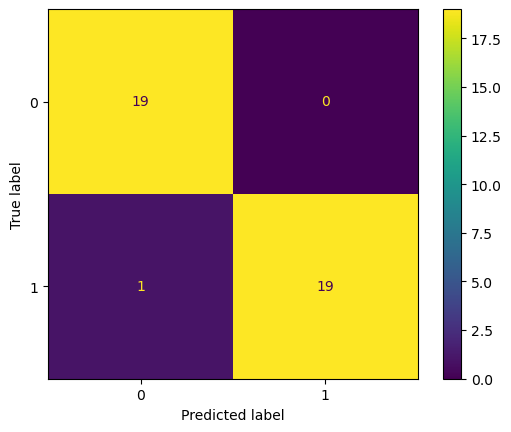

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 71.62162162162163
Saving after new best accuracy : 74.32432432432432
Saving after new best accuracy : 83.78378378378379
Saving after new best accuracy : 89.1891891891892
-- Epoch 50, Train_Accuracy : 98.66220735785953, Validation Accuracy : 86.48648648648648, Train Loss : 0.04203810542821884, Validation Loss : 0.3526335656642914
-- Epoch 100, Train_Accuracy : 99.33110367892976, Validation Accuracy : 87.83783783783784, Train Loss : 0.013984236866235733, Validation Loss : 0.4294063448905945
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 89.1891891891892, Train Loss : 0.0036555936094373465, Validation Loss : 0.4892726540565491
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 89.1891891891892, Train Loss : 0.002140183001756668, Validation Loss : 0.529015839099884
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 87.83783783783784, Train Loss : 0.0007691253558732569, Validation Loss : 0.55307787656

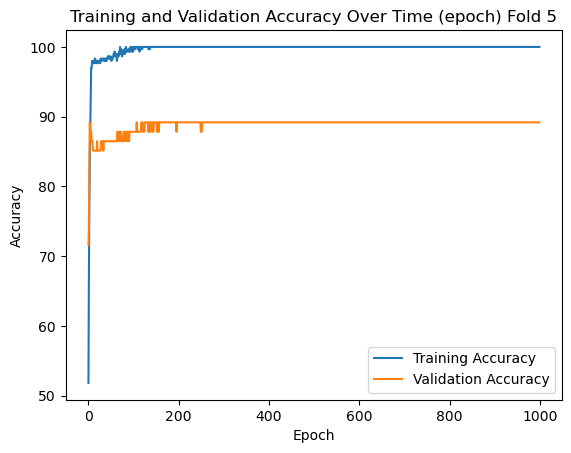

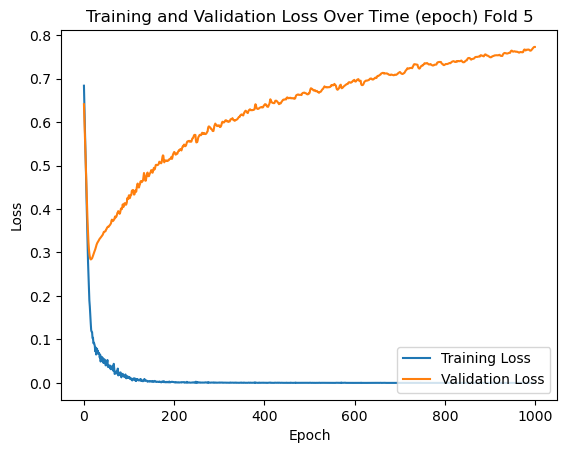

Exec Time : 6.94 seconds
loading model from ../../data/models/cross-validation/Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([299])
Binary Class Evaluation

True Positive : 139
False Positive : 1
False Negative : 9
True Negative : 150

Class False Evaluation
- Precision : 99.286 %
- Recall : 93.919 %
- F1 : 0.96528

Class True Evaluation
- Precision : 94.34 %
- Recall : 99.338 %
- F1 : 0.96774

Combined Evaluation
- Accuracy : 96.656 %
- Precision : 96.813 %
- Recall : 96.628 %
- F1 : 0.9672
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold5 Train, 96.656, 96.813, 96.628, 0.9672, 99.286, 93.919, 0.96528, 94.34, 99.338, 0.96774, 
Confusion Matrix Scikit-learn: 
[[150   1]
 [  9 139]]


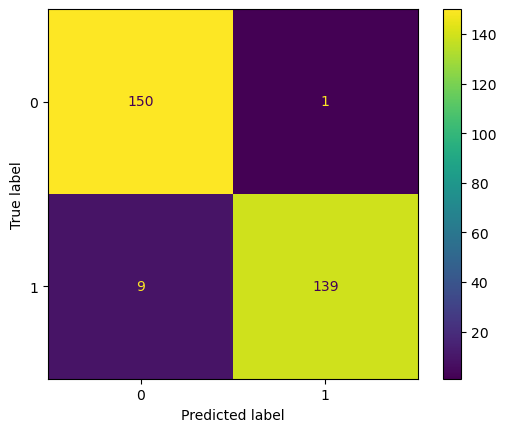


Validation Set
Predictions : torch.Size([74])
Binary Class Evaluation

True Positive : 31
False Positive : 2
False Negative : 6
True Negative : 35

Class False Evaluation
- Precision : 93.939 %
- Recall : 83.784 %
- F1 : 0.88571

Class True Evaluation
- Precision : 85.366 %
- Recall : 94.595 %
- F1 : 0.89744

Combined Evaluation
- Accuracy : 89.189 %
- Precision : 89.653 %
- Recall : 89.189 %
- F1 : 0.8942
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold5 Validation, 89.189, 89.653, 89.189, 0.8942, 93.939, 83.784, 0.88571, 85.366, 94.595, 0.89744, 
Confusion Matrix Scikit-learn: 
[[35  2]
 [ 6 31]]


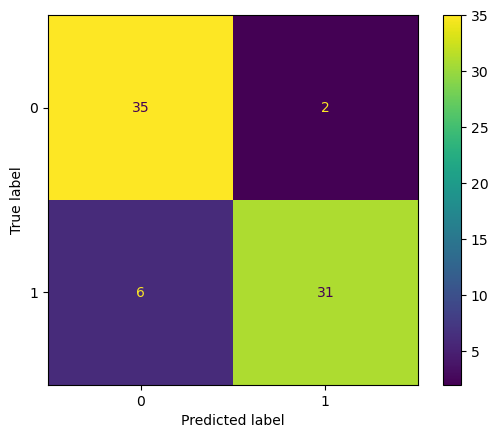


Test Set
Predictions : torch.Size([39])
Binary Class Evaluation

True Positive : 13
False Positive : 0
False Negative : 7
True Negative : 19

Class False Evaluation
- Precision : 100.0 %
- Recall : 65.0 %
- F1 : 0.78788

Class True Evaluation
- Precision : 73.077 %
- Recall : 100.0 %
- F1 : 0.84444

Combined Evaluation
- Accuracy : 82.051 %
- Precision : 86.538 %
- Recall : 82.5 %
- F1 : 0.84471
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter16-TF_2LayerNet_L2Reg_BERT_Finetuned_Fold5 Test, 82.051, 86.538, 82.5, 0.84471, 100.0, 65.0, 0.78788, 73.077, 100.0, 0.84444, 
39
39
Confusion Matrix Scikit-learn: 
[[19  0]
 [ 7 13]]


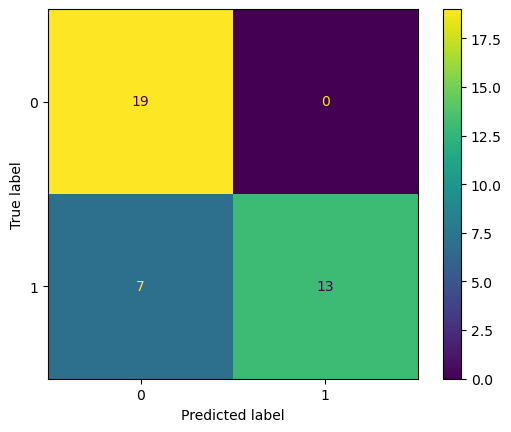

In [12]:
print("Multiclass Classification using 2-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_2LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()